# Predict Fertilizer Comepetitions

## Loading Libraries

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Check Datasets

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Temparature                750000 non-null  int64  
 1   Humidity                   750000 non-null  int64  
 2   Moisture                   750000 non-null  int64  
 3   Soil Type                  750000 non-null  object 
 4   Crop Type                  750000 non-null  object 
 5   Nitrogen                   750000 non-null  int64  
 6   Potassium                  750000 non-null  int64  
 7   Phosphorous                750000 non-null  int64  
 8   Fertilizer Name            750000 non-null  object 
 9   BIN_Temparature            750000 non-null  int64  
 10  BIN_Temparature_Soil Type  750000 non-null  object 
 11  BIN_Temparature_Crop Type  750000 non-null  object 
 12  Total_Nutrients            750000 non-null  int64  
 13  N_P                        750000 

In [138]:
data = pd.read_csv('data/train.csv', index_col = 0)

data.head()

Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  Potassium  \
id                                                                              
0            37        70        36    Clayey  Sugarcane        36          4   
1            27        69        65     Sandy    Millets        30          6   
2            29        63        32     Sandy    Millets        24         12   
3            35        62        54     Sandy     Barley        39         12   
4            35        58        43       Red      Paddy        37          2   

    Phosphorous Fertilizer Name  
id                               
0             5           28-28  
1            18           28-28  
2            16        17-17-17  
3             4        10-26-26  
4            16             DAP

In [42]:
data.describe()

Temparature       Humidity       Moisture       Nitrogen  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       31.503565      61.038912      45.184147      23.093808   
std         4.025574       6.647695      11.794594      11.216125   
min        25.000000      50.000000      25.000000       4.000000   
25%        28.000000      55.000000      35.000000      13.000000   
50%        32.000000      61.000000      45.000000      23.000000   
75%        35.000000      67.000000      55.000000      33.000000   
max        38.000000      72.000000      65.000000      42.000000   

           Potassium    Phosphorous  
count  750000.000000  750000.000000  
mean        9.478296      21.073227  
std         5.765622      12.346831  
min         0.000000       0.000000  
25%         4.000000      10.000000  
50%         9.000000      21.000000  
75%        14.000000      32.000000  
max        19.000000      42.000000

In [43]:
data.dtypes

Temparature         int64
Humidity            int64
Moisture            int64
Soil Type          object
Crop Type          object
Nitrogen            int64
Potassium           int64
Phosphorous         int64
Fertilizer Name    object
dtype: object

## Define Target, Quantitative, Categorical Columns

In [44]:
TARGET = 'Fertilizer Name'
QUAN_COLUMNS = [col for col in data.columns if data[col].dtype != 'object' and col != TARGET]
CAT_COLUMNS = [col for col in data.columns if data[col].dtype == 'object' and col != TARGET]

print('Target column:', TARGET)
print('Quantitative columns:', QUAN_COLUMNS)
print('Categorical columns:', CAT_COLUMNS)

Target column: Fertilizer Name
Quantitative columns: ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
Categorical columns: ['Soil Type', 'Crop Type']


# 1. Check Distribution of Data and TARGET influences

## Useful method 
- Gini Coefficient : Check Class Imbalance. 0 if perfect balance and 1 if perfect imbalance.
- R^2 : Check linear relationship between two predictors.

In [59]:
def gini_coefficient(array):
    """
    Gini 계수를 계산합니다. 클래스별 샘플 수 또는 값의 배열을 입력으로 받습니다.

    Args:
        array (list or np.ndarray): 값의 리스트 (예: 클래스별 샘플 수, 소득 등)

    Returns:
        float: Gini Coefficient (0 = 완전 균형, 1 = 극단적 불균형)
    """
    array = np.array(array, dtype=np.float64)
    if np.amin(array) < 0:
        raise ValueError("Gini coefficient is not defined for negative values")

    if array.sum() == 0:
        return 0.0  # 모든 값이 0이면 균형으로 간주

    array = np.sort(array)  # 오름차순 정렬
    n = array.shape[0]
    cumulative = np.cumsum(array)
    index = np.arange(1, n + 1)

    gini = (2 * np.sum(index * array)) / (n * np.sum(array)) - (n + 1) / n
    return gini


In [64]:
def r2_score(X, y):
    """
    R^2 (결정계수)를 계산합니다. X는 독립 변수, y는 종속 변수입니다.

    Args:
        X (np.ndarray): 독립 변수 배열
        y (np.ndarray): 종속 변수 배열

    Returns:
        float: R^2 score
    """
    y_mean = np.mean(y)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_residual = np.sum((y - X @ np.linalg.lstsq(X, y, rcond=None)[0]) ** 2)
    return 1 - (ss_residual / ss_total)

In [161]:
# Color Palette for BoxPlot.
col_values = data[TARGET].unique()
col_colors = sns.color_palette("husl", len(col_values))

## For Target Columns

<Axes: xlabel='Fertilizer Name', ylabel='Count'>

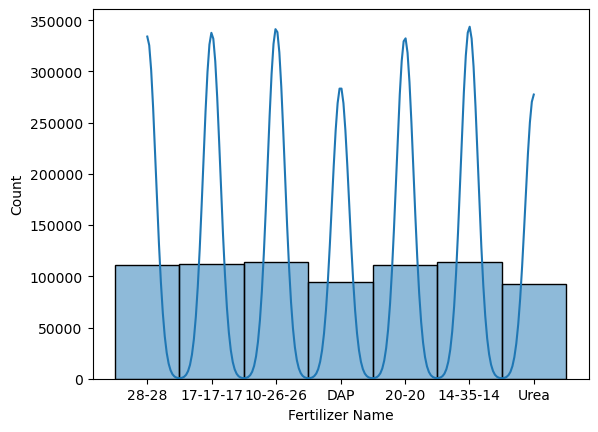

In [47]:
sns.histplot(data, x = TARGET, kde= True, stat = 'count')

In [62]:
gini = gini_coefficient(data[TARGET].value_counts().to_numpy())
print(f"Gini Coefficient for TARGET: {gini:.4f}")

Gini Coefficient for TARGET: 0.0404


- Target column is simliar to uniform distribution
- Gini Coefficient of TARGET is 0.04 : Almost perfect balance.

## For Categorical Columns

### histplot

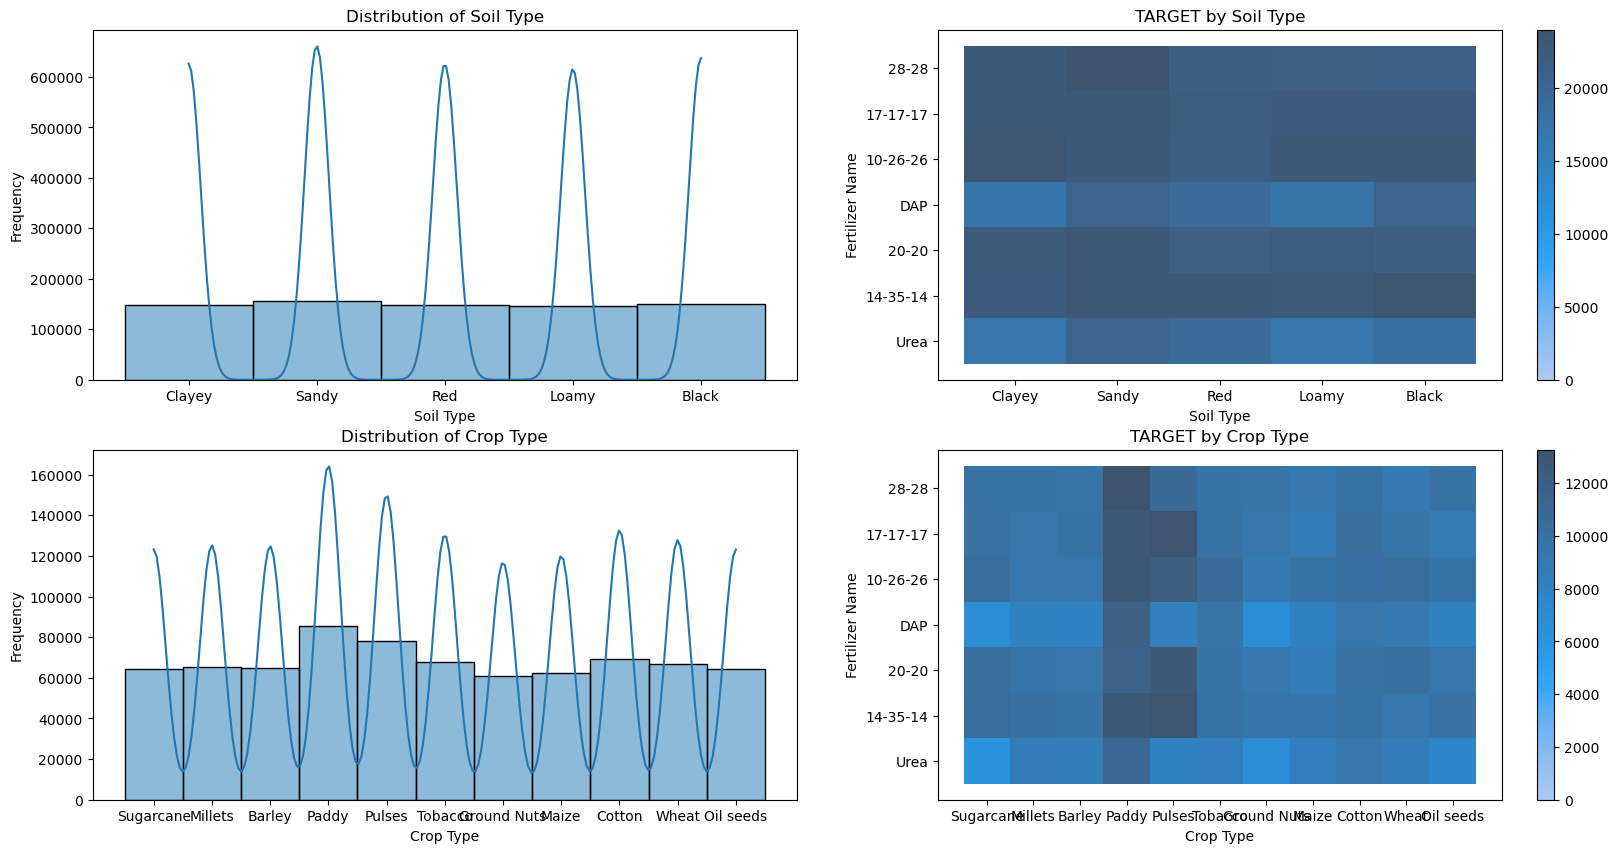

In [145]:
# For Categorical colums : sns.histplot
fig, ax = plt.subplots(len(CAT_COLUMNS), 2, figsize=(20, 10))

for i, col in enumerate(CAT_COLUMNS):
    sns.histplot(data[col], ax=ax[i,0], kde=True)
    ax[i,0].set_title(f'Distribution of {col}')
    ax[i,0].set_xlabel(col)
    ax[i,0].set_ylabel('Frequency')

    sns.histplot(data, x=col, y = TARGET, ax = ax[i,1], cbar=True)
    ax[i,1].set_title(f'TARGET by {col}')
    ax[i,1].set_xlabel(col)
    ax[i,1].set_ylabel(TARGET)


### Gini Coefficient

In [79]:
for col in CAT_COLUMNS:
    gini = gini_coefficient(data[col].value_counts().to_numpy())
    print(f"Gini Coefficient for {col}: {gini:.4f}")

Gini Coefficient for Soil Type: 0.0131
Gini Coefficient for Crop Type: 0.0511


- Category columns are almost uniformly distributed. (Gini Coefficient is small enough to determine Category columns are well balanced.)
- It is reasonable to think there are some correlation between categorical features and target.

## For Quantitative Features

### Pairplot

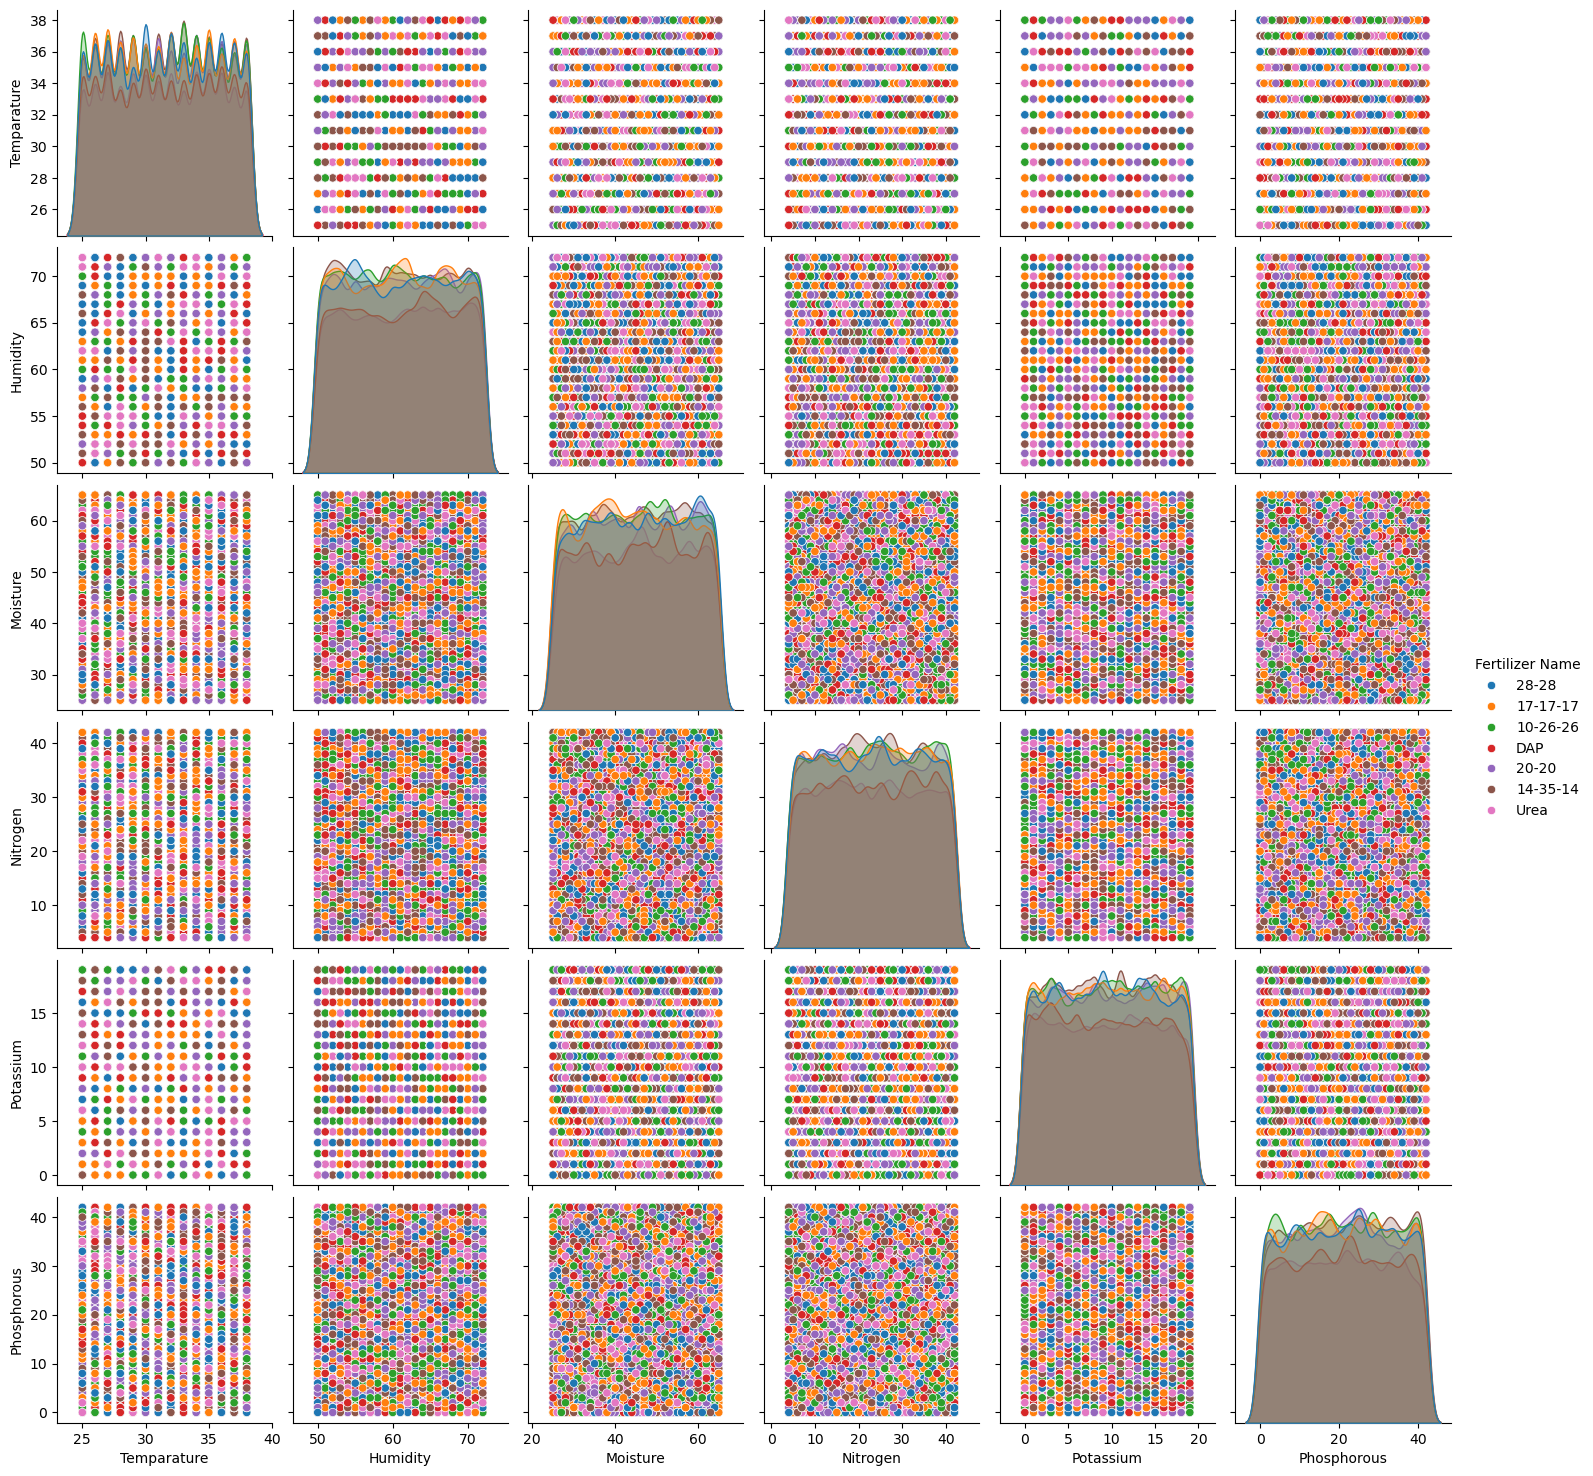

In [48]:
sns.pairplot(data[QUAN_COLUMNS + [TARGET]], hue=TARGET, diag_kind='kde', height=2.5)

### R^2 Score (To check linear relationship)

In [65]:
from itertools import combinations

isLinear = False

for col1, col2 in combinations(QUAN_COLUMNS, 2):
    r2 = r2_score(data[col1].values.reshape(-1, 1), data[col2].values)
    if r2 > 0.2:
        print(f"Linear correlation between {col1} and {col2}: R^2 = {r2:.4f}")
        isLinear = True

if not isLinear:
    print("No significant linear correlation found between quantitative columns.")

No significant linear correlation found between quantitative columns.


### kdeplot and boxplot

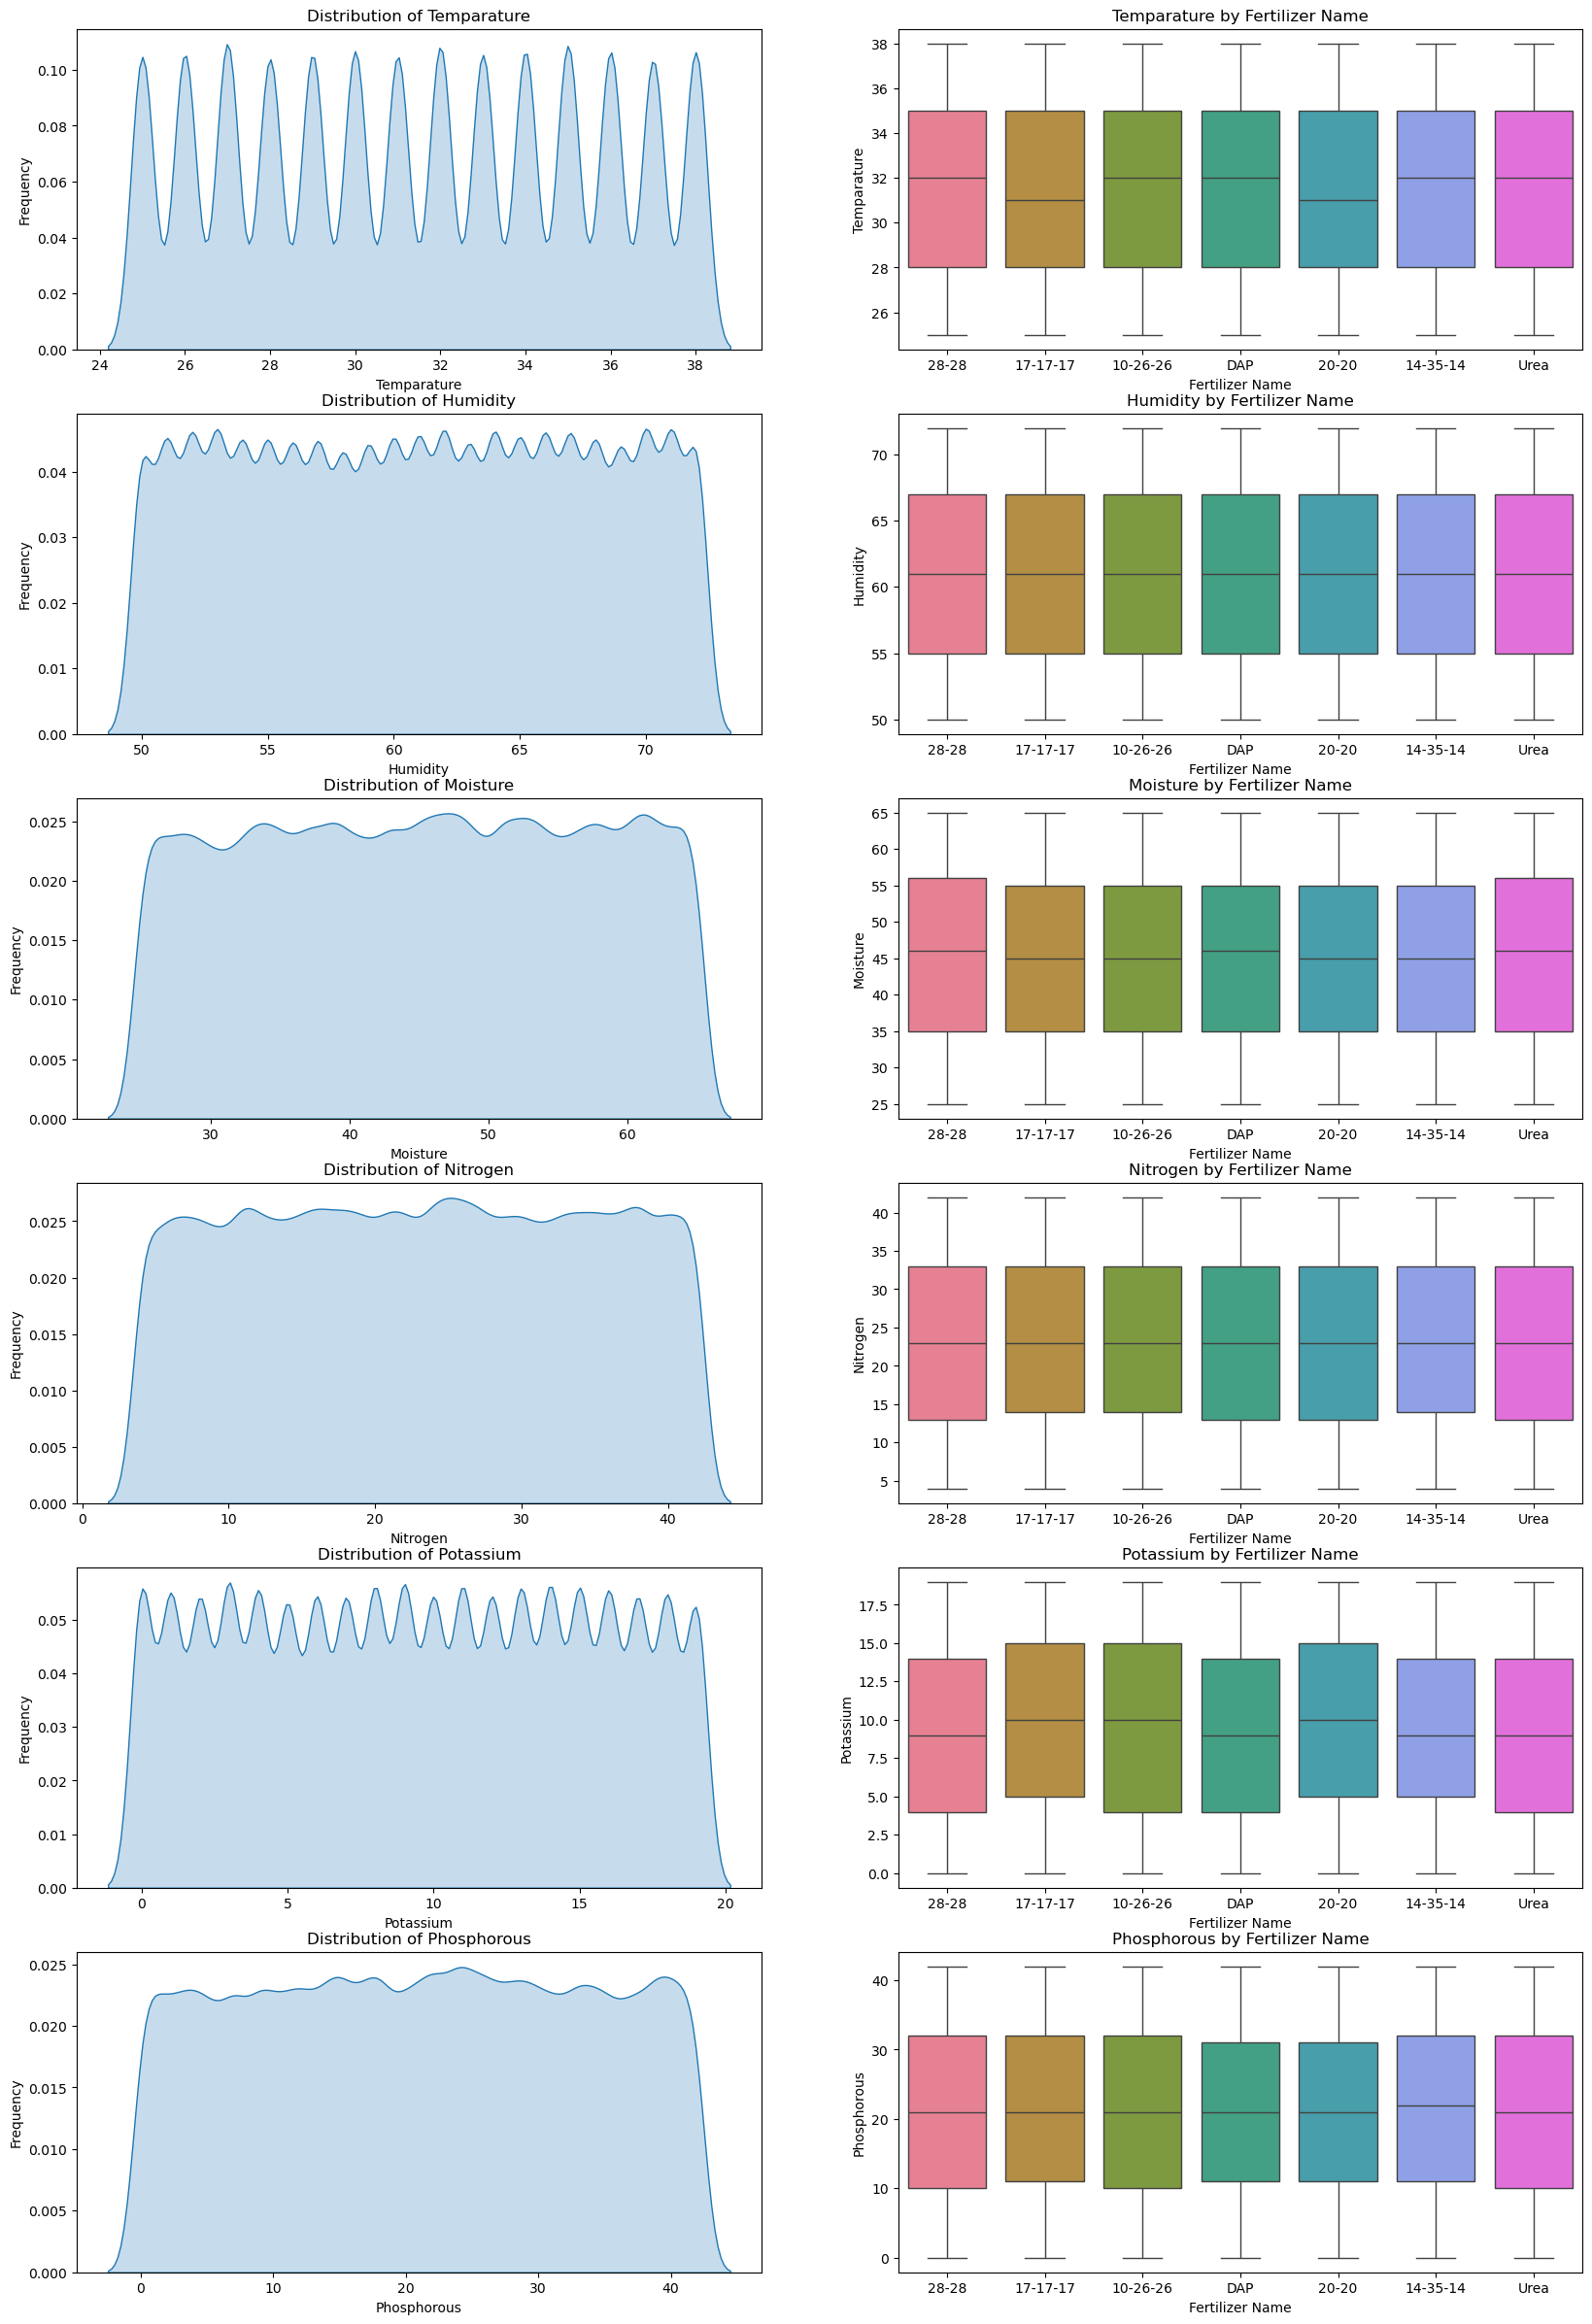

In [162]:
fig, ax = plt.subplots(len(QUAN_COLUMNS), 2, figsize=(20, 30))

for i, col in enumerate(QUAN_COLUMNS):

    sns.kdeplot(data,x = col, ax=ax[i,0], fill=True)
    ax[i,0].set_title(f'Distribution of {col}')
    ax[i,0].set_xlabel(col)
    ax[i,0].set_ylabel('Frequency')

    sns.boxplot(x = TARGET, y=col, data=data, ax=ax[i,1], palette = dict(zip(col_values, col_colors)), legend = False)
    ax[i,1].set_title(f'{col} by {TARGET}')
    ax[i,1].set_xlabel(TARGET)
    ax[i,1].set_ylabel(col)

### Gini Coefficient

In [77]:
for col in QUAN_COLUMNS:
    data_bined = pd.cut(data[col], bins=100, labels = False)
    gini = gini_coefficient(data_bined.value_counts().to_numpy())
    print(f"Gini Coefficient for {col}: {gini:.4f}")

Gini Coefficient for Temparature: 0.0089
Gini Coefficient for Humidity: 0.0133
Gini Coefficient for Moisture: 0.0220
Gini Coefficient for Nitrogen: 0.0176
Gini Coefficient for Potassium: 0.0126
Gini Coefficient for Phosphorous: 0.0223


- Quantitative columns are uniformly distributed. (Gini Coefficient is small enough)
- In terms of median in boxplot: Phosphorous, Potassium, Temperature, Moisture has significant effect on TARGET. Nitrogen and Humidity seems not significant. 
- in Nitrogen, 1Q-3Q(box)s are different a little. However, Humidity's 1Q-3Q(box)s are very similar to each other.

# Check Interaction Effect

## 1. CAT_CAT Interaction

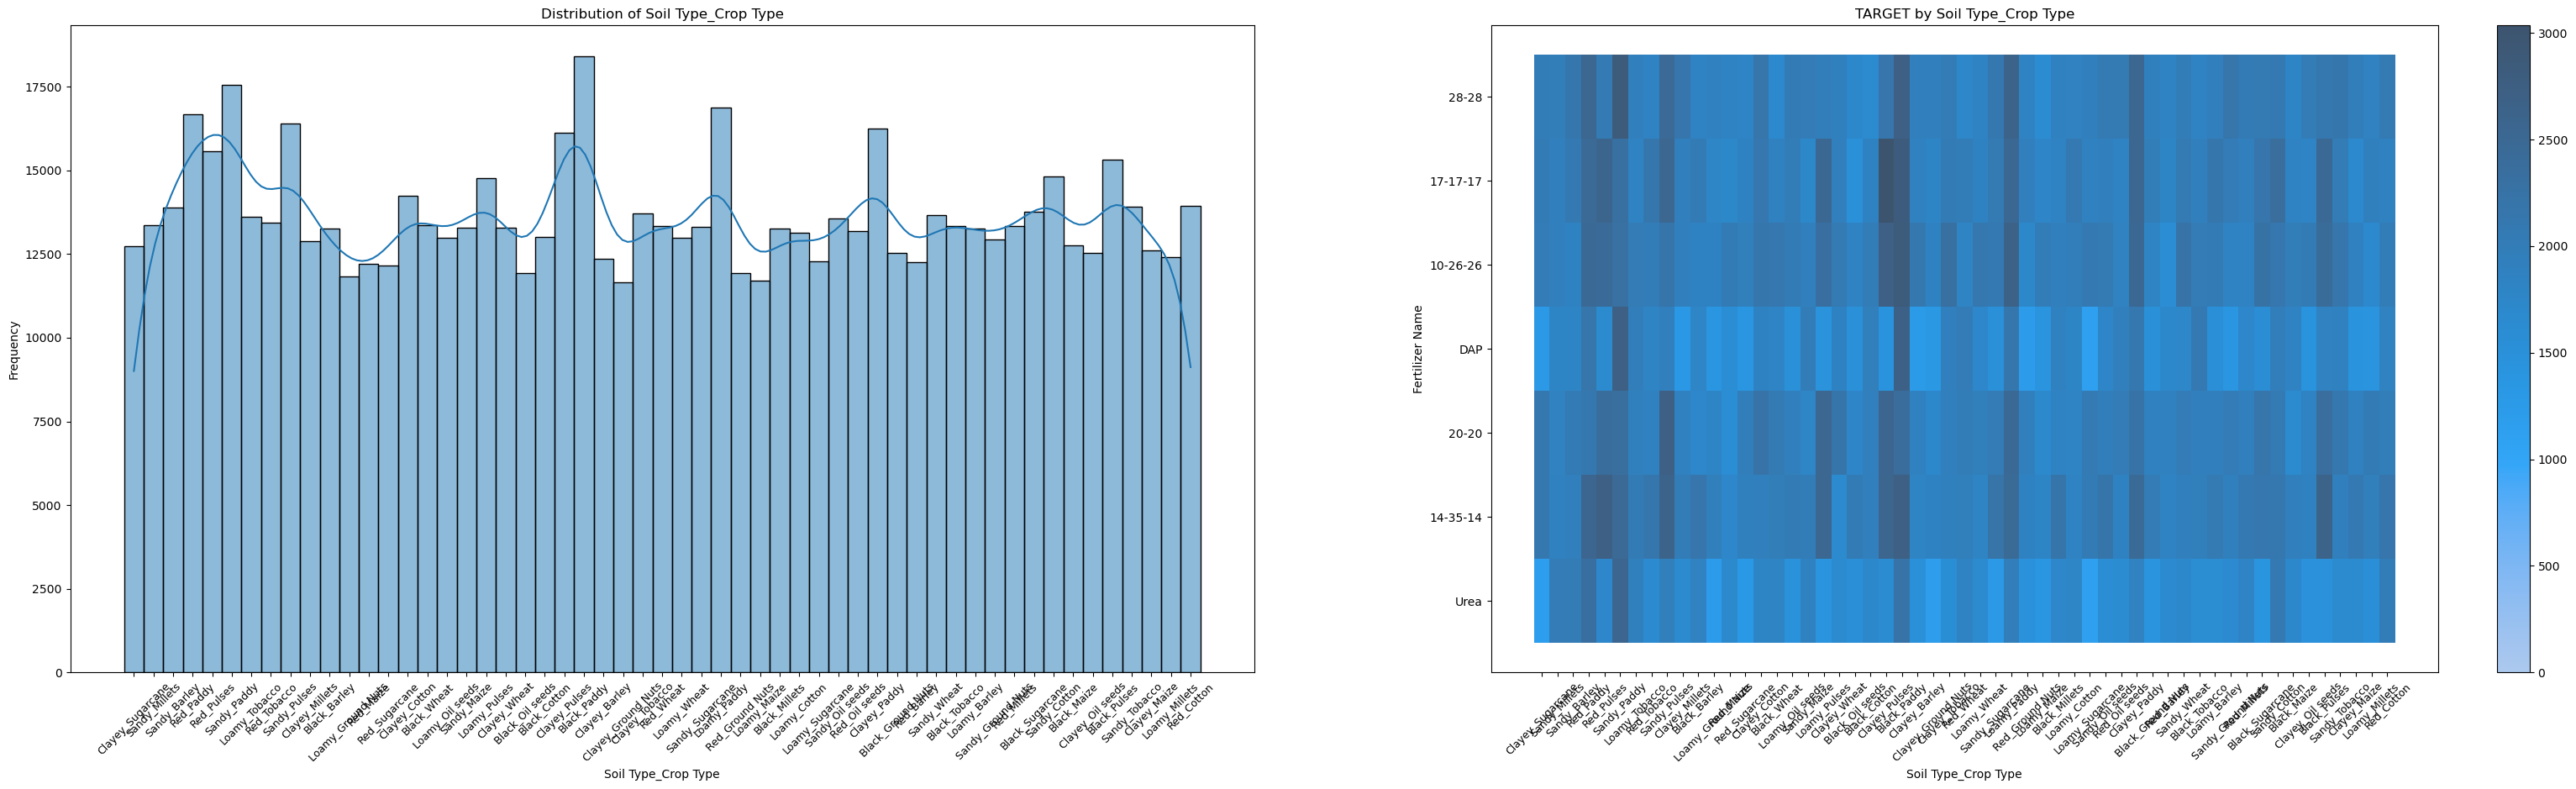

In [ ]:
comb = list(combinations(CAT_COLUMNS, 2))
n = len(comb)
fig, ax = plt.subplots(n, 2, figsize=(40, 10 * n), squeeze=False)

for i, (col1, col2) in enumerate(comb):
    NEW_COL_NAME = f"{col1}_{col2}"
    data[NEW_COL_NAME] = data[col1].astype(str) + "_" + data[col2].astype(str)

    sns.histplot(data[NEW_COL_NAME], ax=ax[i, 0], kde=True)
    ax[i, 0].set_title(f'Distribution of {NEW_COL_NAME}')
    ax[i, 0].set_xlabel(NEW_COL_NAME)
    ax[i ,0].tick_params(axis = 'x', rotation = 45, labelsize = 9)
    ax[i, 0].set_ylabel('Frequency')

    sns.histplot(data, x=NEW_COL_NAME, y=TARGET, ax=ax[i, 1], cbar=True, stat = 'density')
    ax[i, 1].set_title(f'TARGET by {NEW_COL_NAME}')
    ax[i, 1].set_xlabel(NEW_COL_NAME)
    ax[i, 1].tick_params(axis = 'x', rotation = 45, labelsize = 9)
    ax[i, 1].set_ylabel(TARGET)


## Quan_Quan Interaction

### Product-Interaction Term

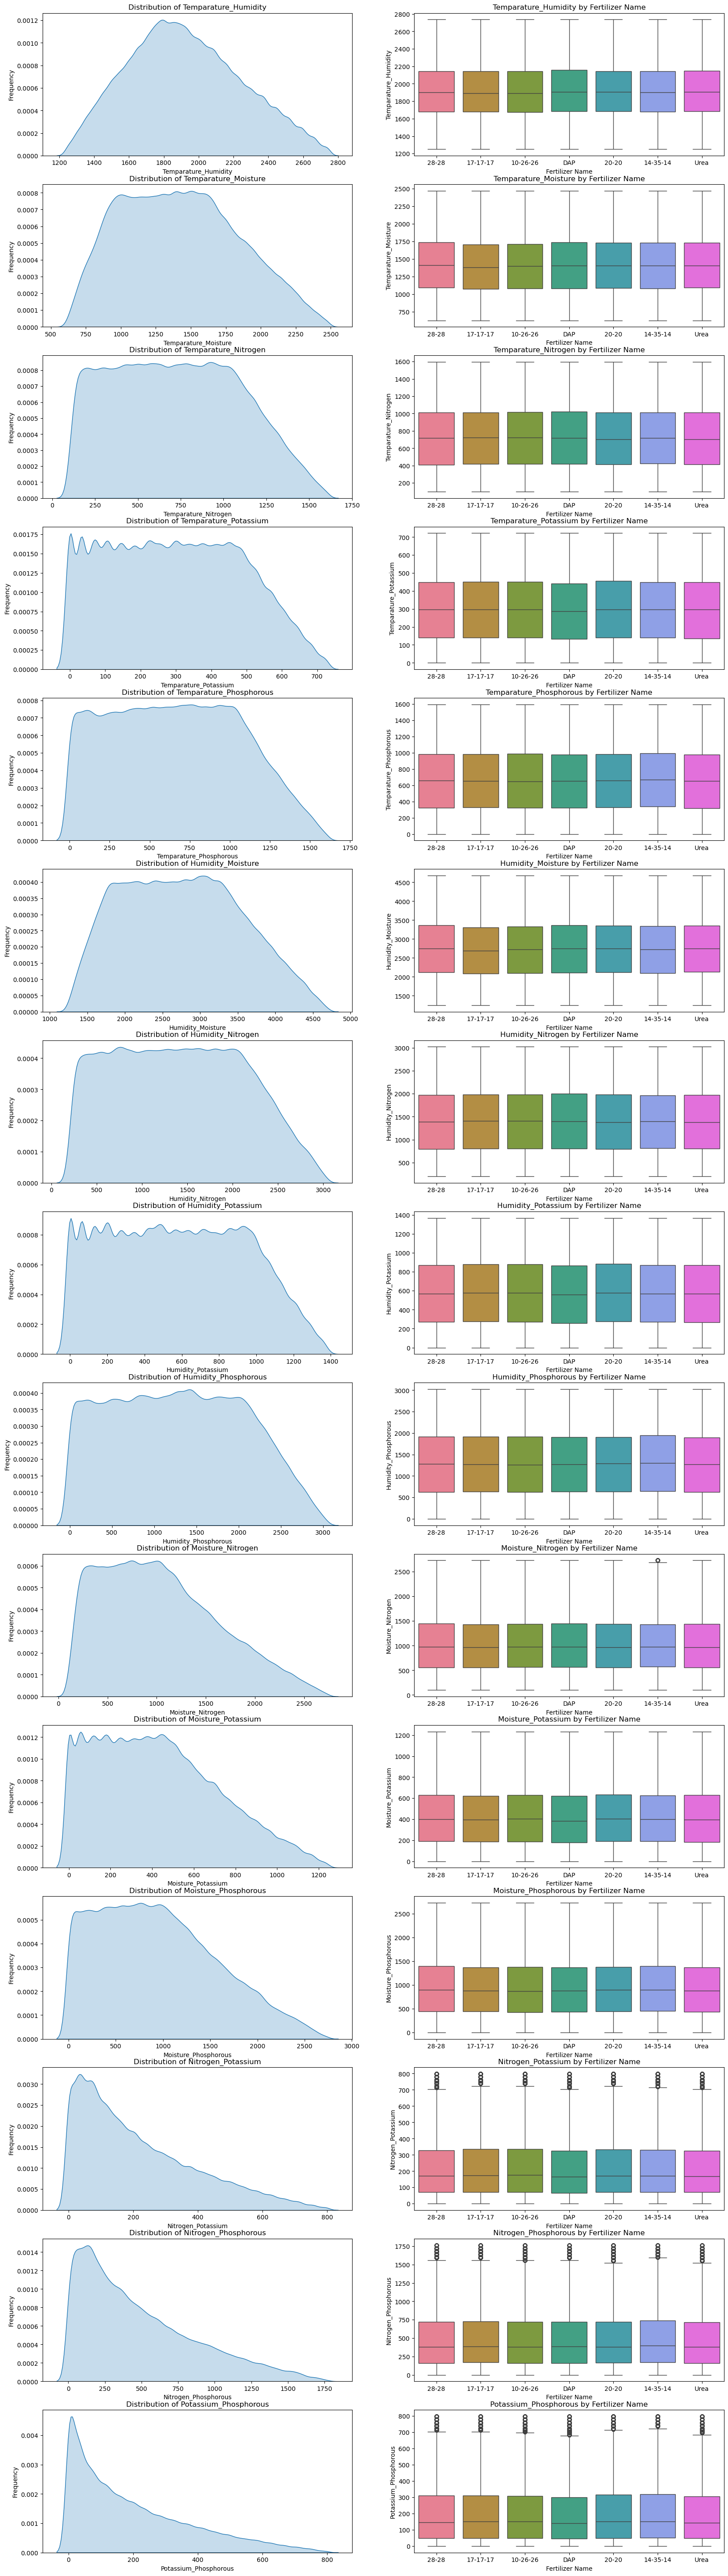

In [ ]:
comb = list(combinations(QUAN_COLUMNS, 2))
n = len(comb)
fig, ax = plt.subplots(n, 2, figsize=(20, 5 * n), squeeze=False)

for i, (col1, col2) in enumerate(comb):
    NEW_COL_NAME = f"{col1}_{col2}"
    data[NEW_COL_NAME] = data[col1] * data[col2]

    sns.kdeplot(data[NEW_COL_NAME], ax=ax[i, 0], fill=True)
    ax[i, 0].set_title(f'Distribution of {NEW_COL_NAME}')
    ax[i, 0].set_xlabel(NEW_COL_NAME)
    ax[i, 0].set_ylabel('Frequency')

    sns.boxplot(x=TARGET, y=NEW_COL_NAME, data=data, ax=ax[i, 1], palette=dict(zip(col_values, col_colors)))
    ax[i, 1].set_title(f'{NEW_COL_NAME} by {TARGET}')
    ax[i, 1].set_xlabel(TARGET)
    ax[i, 1].set_ylabel(NEW_COL_NAME)


### Temperature_CAT Interaction Effect

Change temperature into categorical.

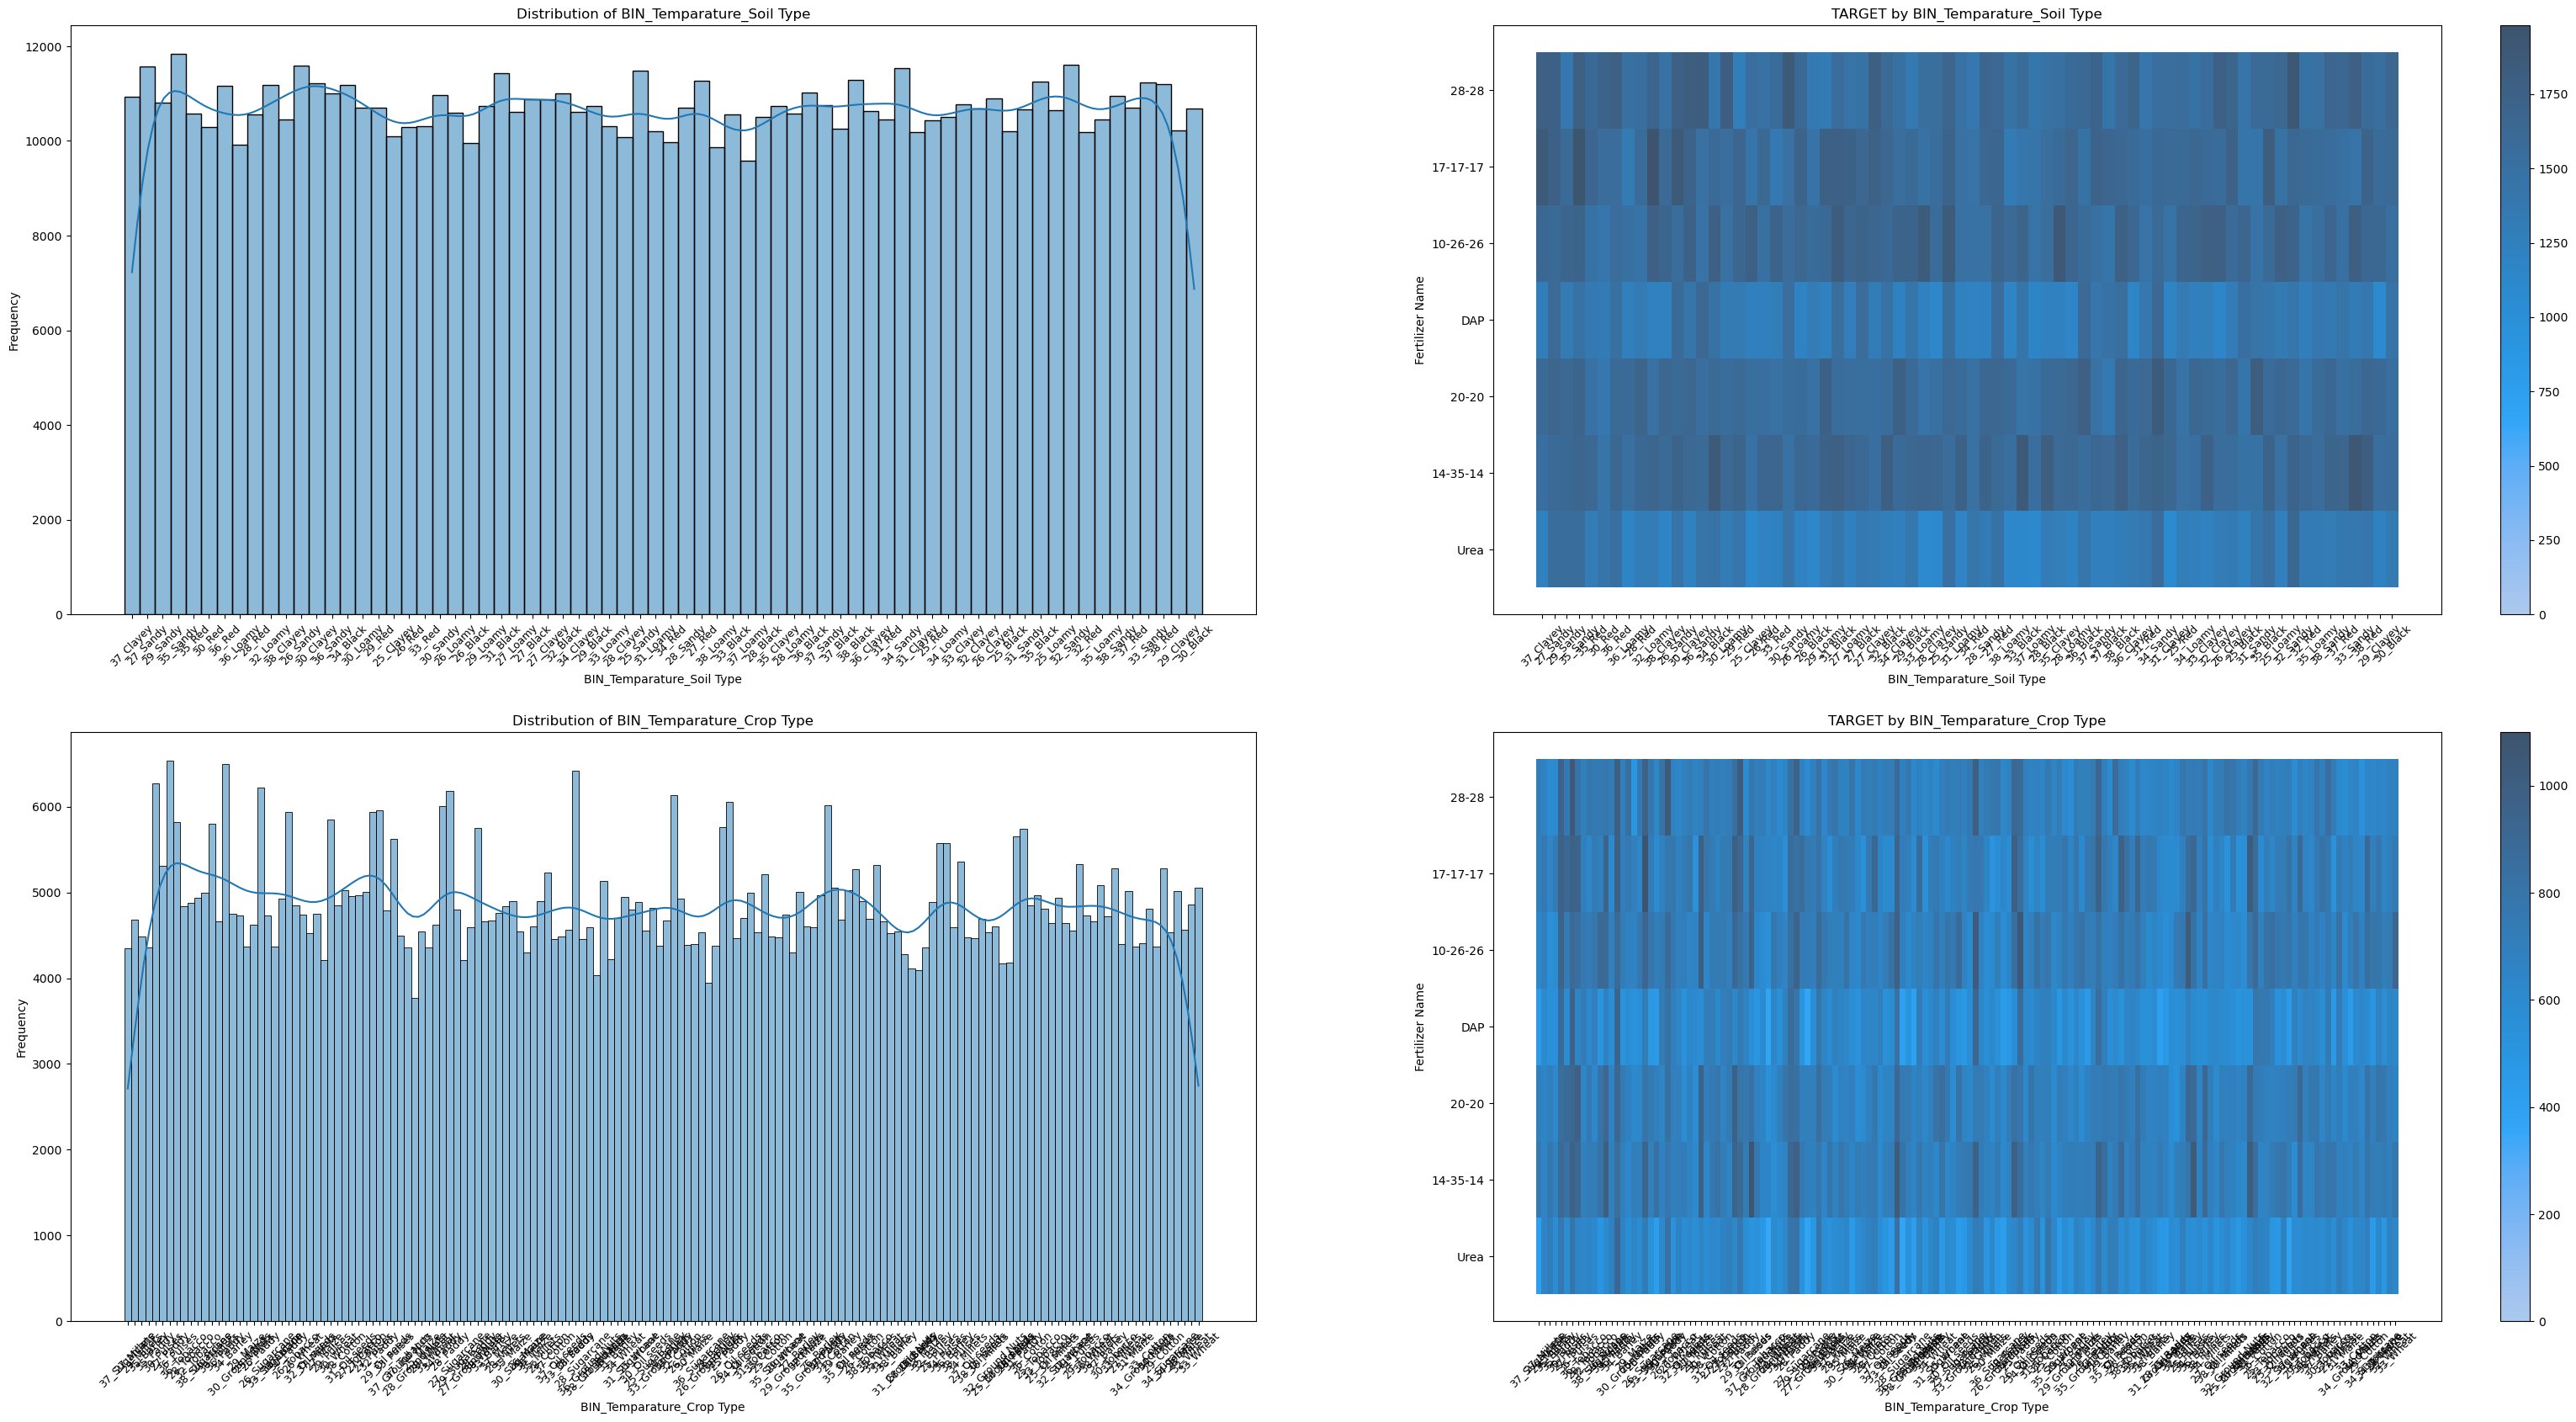

In [ ]:
n = len(CAT_COLUMNS)
fig, ax = plt.subplots(n, 2, figsize=(40, 10 * n), squeeze=False)
data["BIN_Temparature"] = data['Temparature'].astype(int)

for i, col1 in enumerate(CAT_COLUMNS):
    NEW_COL_NAME = f"BIN_Temparature_{col1}"
    data[NEW_COL_NAME] = data["BIN_Temparature"].astype(str) + "_" + data[col1].astype(str)

    sns.histplot(data[NEW_COL_NAME], ax=ax[i, 0], kde=True)
    ax[i, 0].set_title(f'Distribution of {NEW_COL_NAME}')
    ax[i, 0].set_xlabel(NEW_COL_NAME)
    ax[i ,0].tick_params(axis = 'x', rotation = 45, labelsize = 9)
    ax[i, 0].set_ylabel('Frequency')

    sns.histplot(data, x=NEW_COL_NAME, y=TARGET, ax=ax[i, 1], cbar=True)
    ax[i, 1].set_title(f'TARGET by {NEW_COL_NAME}')
    ax[i, 1].set_xlabel(NEW_COL_NAME)
    ax[i, 1].tick_params(axis = 'x', rotation = 45, labelsize = 9)
    ax[i, 1].set_ylabel(TARGET)


# Domain-Specific Features

- **Total Nutrients** : Sum of Nitrogen, Phosphorous, and Potassium. 
- **N_P Ratio** : Nitrogen / (k + Phosphorous) 
- **K_P Ratio** : Potassium / (k + Phosphorous)
- **Humidity_Moisture Ratio** : Humidity / (1 + Moisture)

## Total Nutrients

Text(0, 0.5, 'Total Nutrients')

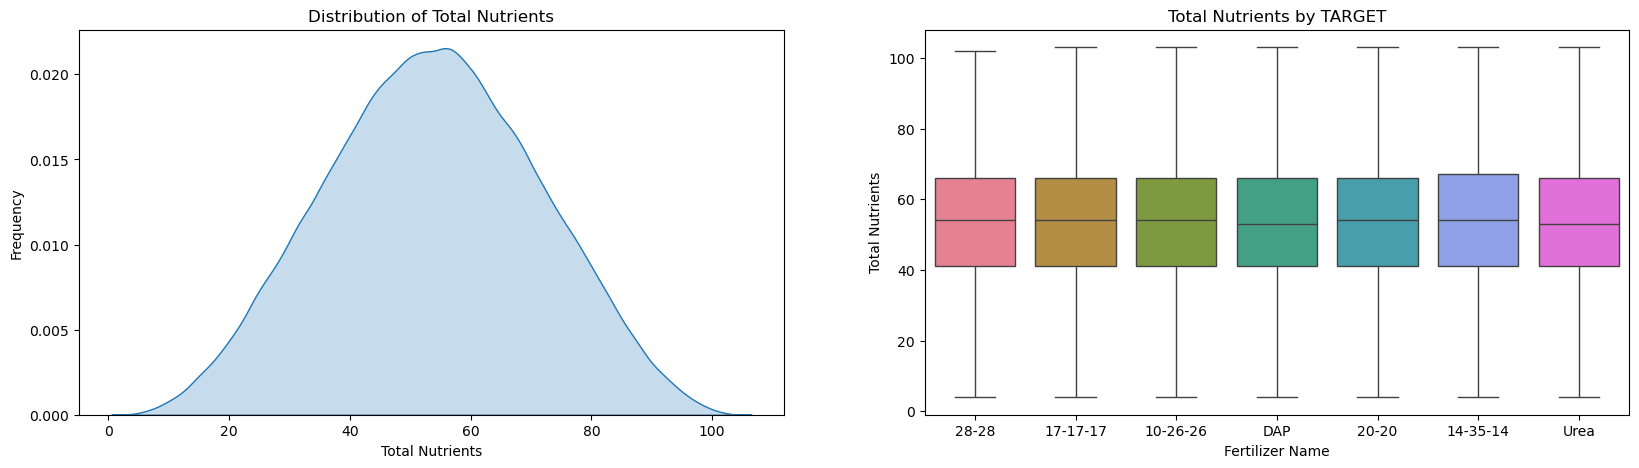

In [163]:
data['Total_Nutrients'] = data['Nitrogen'] + data['Phosphorous'] + data['Potassium']
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(data['Total_Nutrients'], ax=ax[0], fill=True)
ax[0].set_title('Distribution of Total Nutrients')
ax[0].set_xlabel('Total Nutrients')
ax[0].set_ylabel('Frequency')

sns.boxplot(x=TARGET, y='Total_Nutrients', data=data, ax=ax[1], palette=dict(zip(col_values, col_colors)))
ax[1].set_title('Total Nutrients by TARGET')
ax[1].set_xlabel(TARGET)
ax[1].set_ylabel('Total Nutrients')

## N_P Ratio

Text(0, 0.5, 'N/P Ratio')

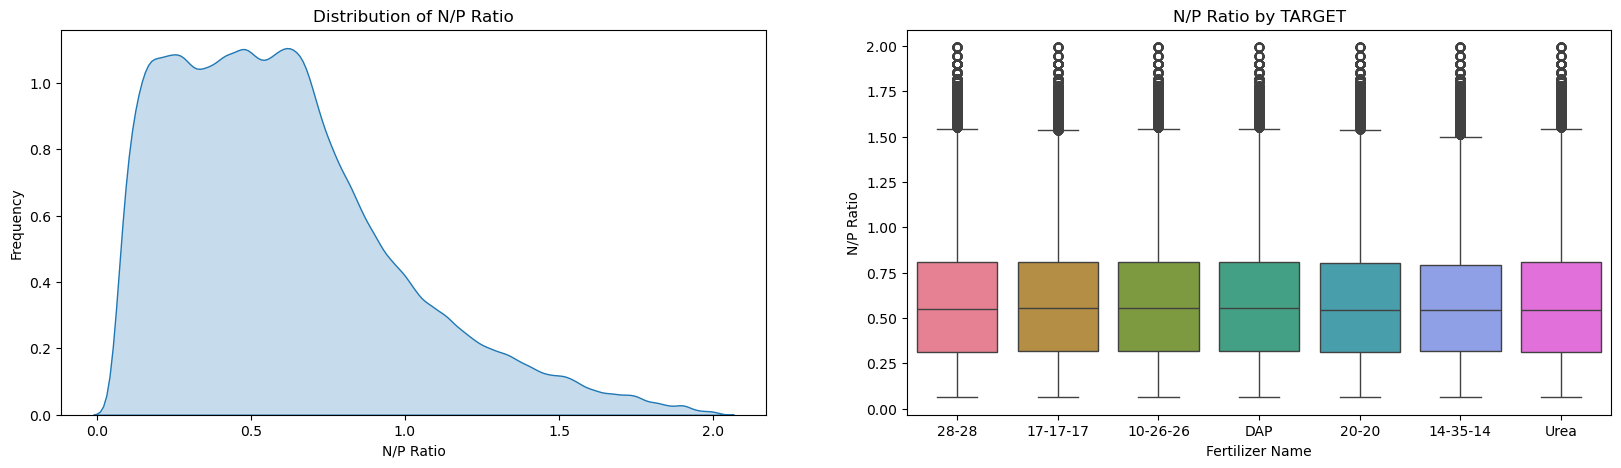

In [164]:
k = data['Phosphorous'].mean() # smoothing factor to 1. avoid division by zero 2. to avoid too extreme values

data['N_P'] = data['Nitrogen'] / (data['Phosphorous'] + k)  # Avoid division by zero

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(data['N_P'], ax=ax[0], fill=True)
ax[0].set_title('Distribution of N/P Ratio')
ax[0].set_xlabel('N/P Ratio')
ax[0].set_ylabel('Frequency')

sns.boxplot(x=TARGET, y='N_P', data=data, ax=ax[1], palette=dict(zip(col_values, col_colors)))
ax[1].set_title('N/P Ratio by TARGET')
ax[1].set_xlabel(TARGET)
ax[1].set_ylabel('N/P Ratio')

## K_P Ratio

Text(0, 0.5, 'K/P Ratio')

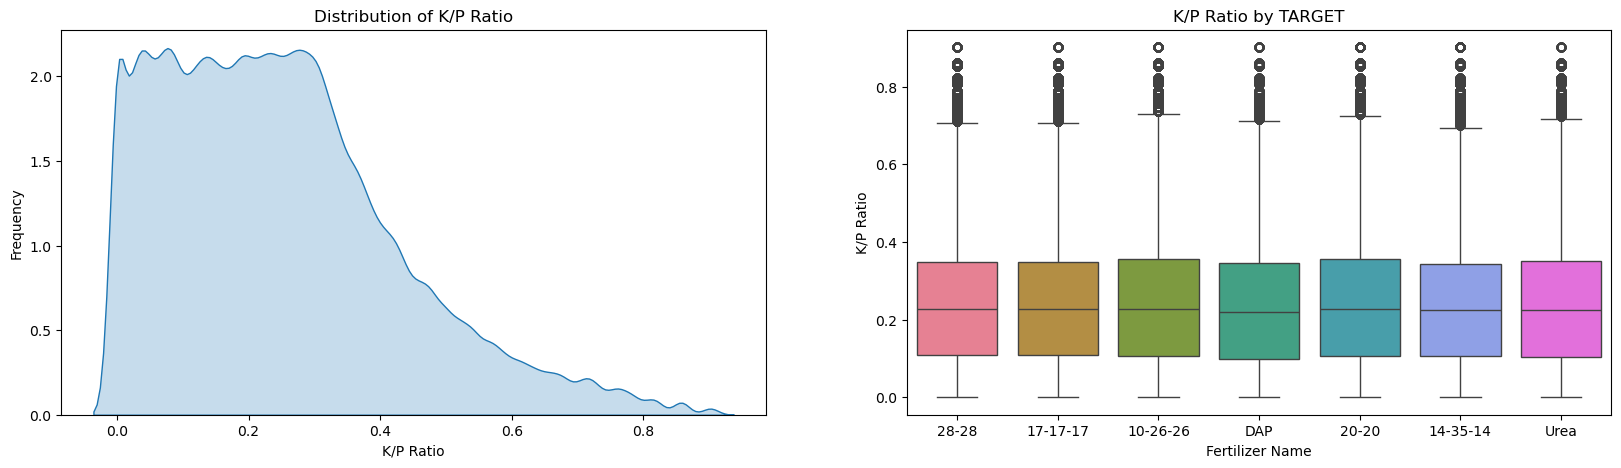

In [165]:
k = data['Phosphorous'].mean() # smoothing factor to 1. avoid division by zero 2. to avoid too extreme values

data['K_P'] = data['Potassium'] / (data['Phosphorous'] + k)  # Avoid division by zero

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(data['K_P'], ax=ax[0], fill=True)
ax[0].set_title('Distribution of K/P Ratio')
ax[0].set_xlabel('K/P Ratio')
ax[0].set_ylabel('Frequency')

sns.boxplot(x=TARGET, y='K_P', data=data, ax=ax[1], palette=dict(zip(col_values, col_colors)))
ax[1].set_title('K/P Ratio by TARGET')
ax[1].set_xlabel(TARGET)
ax[1].set_ylabel('K/P Ratio')

## Humidity_Mositure (H_M) Ratio

Text(0, 0.5, 'H/M Ratio')

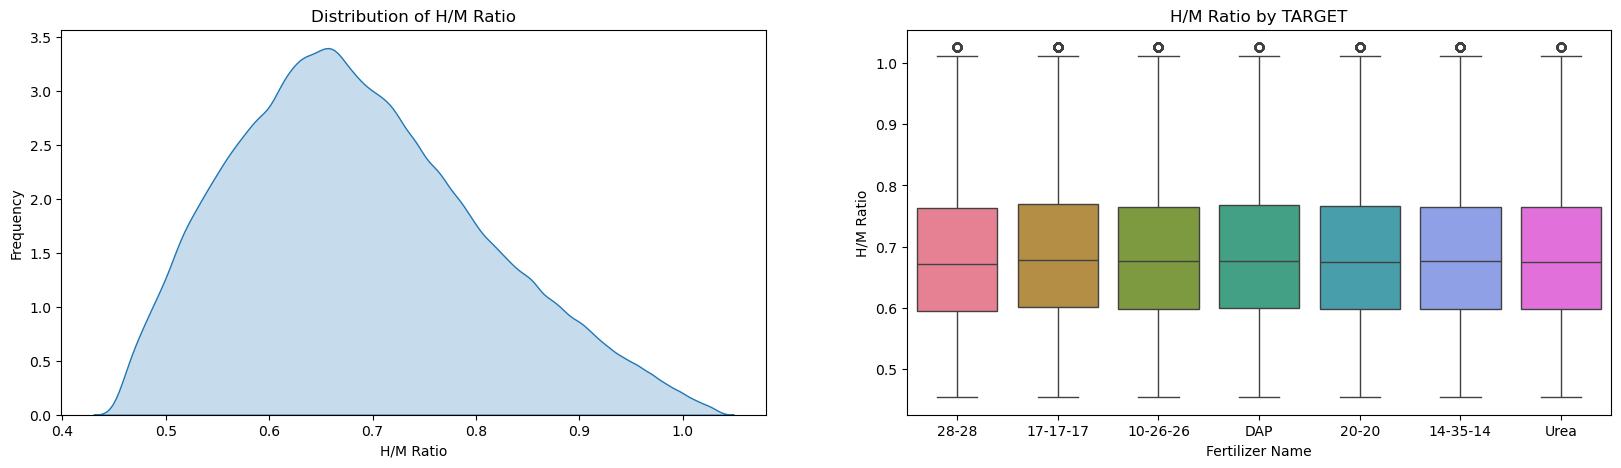

In [166]:
k = data['Moisture'].mean() # smoothing factor to 1. avoid division by zero 2. to avoid too extreme values

data['H_M'] = data['Humidity'] / (data['Moisture'] + k)  # Avoid division by zero

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(data['H_M'], ax=ax[0], fill=True)
ax[0].set_title('Distribution of H/M Ratio')
ax[0].set_xlabel('H/M Ratio')
ax[0].set_ylabel('Frequency')

sns.boxplot(x=TARGET, y='H_M', data=data, ax=ax[1], palette=dict(zip(col_values, col_colors)))
ax[1].set_title('H/M Ratio by TARGET')
ax[1].set_xlabel(TARGET)
ax[1].set_ylabel('H/M Ratio')